In [2]:
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Polygon, Point, box, shape
# from shapely.algorithms.polylabel import polylabel
from descartes import PolygonPatch
%matplotlib inline

In [3]:
initial_polygon = Polygon([
    (0.0, 0.0),
    (4.0, 0.0),
    (4.0, 1.0),
    (1.0, 1.0),
    (1.0, 4.0),
    (0.0, 4.0),
    (0.0, 0.0)
])

In [3]:
quad_polygons = [
    Polygon(((1, 1), (3, 1), (3, 3), (1, 3))),
    Polygon(((0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5))),
    Polygon(((1.25, 1.25), (1.75, 1.25), (1.75, 1.75), (1.25, 1.75))),
    Polygon(((1.625, 1.125), (1.875, 1.125), (1.875, 1.375), (1.625, 1.375))),
    Polygon(((1.125, 1.125), (1.375, 1.125), (1.375, 1.375), (1.125, 1.375))),
    Polygon(((1.125, 1.625), (1.375, 1.625), (1.375, 1.875), (1.125, 1.875))),
    Polygon(((0.25, 1.25), (0.75, 1.25), (0.75, 1.75), (0.25, 1.75))),
    Polygon(((0.125, 1.125), (0.375, 1.125), (0.375, 1.375), (0.125, 1.375))),
    Polygon(((0.625, 1.625), (0.875, 1.625), (0.875, 1.875), (0.625, 1.875))),
    Polygon(((0.625, 1.125), (0.875, 1.125), (0.875, 1.375), (0.625, 1.375))),
    Polygon(((0.125, 1.625), (0.375, 1.625), (0.375, 1.875), (0.125, 1.875))),
    Polygon(((0.25, 0.25), (0.75, 0.25), (0.75, 0.75), (0.25, 0.75))),
    Polygon(((0.125, 0.125), (0.375, 0.125), (0.375, 0.375), (0.125, 0.375))),
    Polygon(((0.125, 0.625), (0.375, 0.625), (0.375, 0.875), (0.125, 0.875))),
    Polygon(((0.625, 0.125), (0.875, 0.125), (0.875, 0.375), (0.625, 0.375))),
    Polygon(((0.625, 0.625), (0.875, 0.625), (0.875, 0.875), (0.625, 0.875))),
    Polygon(((0.5625, 0.5625), (0.6875, 0.5625), (0.6875, 0.6875), (0.5625, 0.6875))),
    Polygon(((1.25, 0.25), (1.75, 0.25), (1.75, 0.75), (1.25, 0.75))),
    Polygon(((2.5, 0.5), (3.5, 0.5), (3.5, 1.5), (2.5, 1.5))),
    Polygon(((3.25, 0.25), (3.75, 0.25), (3.75, 0.75), (3.25, 0.75))),
    Polygon(((2.25, 0.25), (2.75, 0.25), (2.75, 0.75), (2.25, 0.75))),
    Polygon(((0.5, 2.5), (1.5, 2.5), (1.5, 3.5), (0.5, 3.5))),
    Polygon(((0.25, 2.25), (0.75, 2.25), (0.75, 2.75), (0.25, 2.75))),
    Polygon(((0.25, 3.25), (0.75, 3.25), (0.75, 3.75), (0.25, 3.75))),
]

In [26]:
quad_polygons = [
box(0, 0, 4, 4),
box(0, 0, 2, 2),
box(2, 0, 4, 2),
box(0, 2, 2, 4),
box(2, 2, 4, 4),
box(0, 2, 1, 3),
box(1, 2, 2, 3),
box(0, 3, 1, 4),
box(1, 3, 2, 4),
box(1, 2, 1.5, 2.5),
box(1.5, 2, 2, 2.5),
box(1, 2.5, 1.5, 3),
box(1.5, 2.5, 2, 3),
box(1, 2, 1.25, 2.25),
box(1.25, 2, 1.5, 2.25),
box(1, 2.25, 1.25, 2.5),
box(1.25, 2.25, 1.5, 2.5),
box(1, 2.5, 1.25, 2.75),
box(1.25, 2.5, 1.5, 2.75),
box(1, 2.75, 1.25, 3),
box(1.25, 2.75, 1.5, 3),
box(1, 3, 1.5, 3.5),
box(1.5, 3, 2, 3.5),
box(1, 3.5, 1.5, 4),
box(1.5, 3.5, 2, 4),
box(1, 3, 1.25, 3.25),
box(1.25, 3, 1.5, 3.25),
box(1, 3.25, 1.25, 3.5),
box(1.25, 3.25, 1.5, 3.5),
box(1, 3.5, 1.25, 3.75),
box(1.25, 3.5, 1.5, 3.75),
box(1, 3.75, 1.25, 4),
box(1.25, 3.75, 1.5, 4),
box(0, 2, 0.5, 2.5),
box(0.5, 2, 1, 2.5),
box(0, 2.5, 0.5, 3),
box(0.5, 2.5, 1, 3),
box(0, 2, 0.25, 2.25),
box(0.25, 2, 0.5, 2.25),
box(0, 2.25, 0.25, 2.5),
box(0.25, 2.25, 0.5, 2.5),
box(0, 2.5, 0.25, 2.75),
box(0.25, 2.5, 0.5, 2.75),
box(0, 2.75, 0.25, 3),
box(0.25, 2.75, 0.5, 3),
box(0.5, 2.5, 0.75, 2.75),
box(0.75, 2.5, 1, 2.75),
box(0.5, 2.75, 0.75, 3),
box(0.75, 2.75, 1, 3),
box(0.5, 2, 0.75, 2.25),
box(0.75, 2, 1, 2.25),
box(0.5, 2.25, 0.75, 2.5),
box(0.75, 2.25, 1, 2.5),
box(0, 3, 0.5, 3.5),
box(0.5, 3, 1, 3.5),
box(0, 3.5, 0.5, 4),
box(0.5, 3.5, 1, 4),
box(0, 3, 0.25, 3.25),
box(0.25, 3, 0.5, 3.25),
box(0, 3.25, 0.25, 3.5),
box(0.25, 3.25, 0.5, 3.5),
box(0.5, 3.5, 0.75, 3.75),
box(0.75, 3.5, 1, 3.75),
box(0.5, 3.75, 0.75, 4),
box(0.75, 3.75, 1, 4),
box(0.5, 3, 0.75, 3.25),
box(0.75, 3, 1, 3.25),
box(0.5, 3.25, 0.75, 3.5),
box(0.75, 3.25, 1, 3.5),
box(0, 3.5, 0.25, 3.75),
box(0.25, 3.5, 0.5, 3.75),
box(0, 3.75, 0.25, 4),
box(0.25, 3.75, 0.5, 4),
box(2, 0, 3, 1),
box(3, 0, 4, 1),
box(2, 1, 3, 2),
box(3, 1, 4, 2),
box(3, 0, 3.5, 0.5),
box(3.5, 0, 4, 0.5),
box(3, 0.5, 3.5, 1),
box(3.5, 0.5, 4, 1),
box(3, 0, 3.25, 0.25),
box(3.25, 0, 3.5, 0.25),
box(3, 0.25, 3.25, 0.5),
box(3.25, 0.25, 3.5, 0.5),
box(3.5, 0.5, 3.75, 0.75),
box(3.75, 0.5, 4, 0.75),
box(3.5, 0.75, 3.75, 1),
box(3.75, 0.75, 4, 1),
box(3.5, 0, 3.75, 0.25),
box(3.75, 0, 4, 0.25),
box(3.5, 0.25, 3.75, 0.5),
box(3.75, 0.25, 4, 0.5),
box(3, 0.5, 3.25, 0.75),
box(3.25, 0.5, 3.5, 0.75),
box(3, 0.75, 3.25, 1),
box(3.25, 0.75, 3.5, 1),
box(2, 0, 2.5, 0.5),
box(2.5, 0, 3, 0.5),
box(2, 0.5, 2.5, 1),
box(2.5, 0.5, 3, 1),
box(2, 0, 2.25, 0.25),
box(2.25, 0, 2.5, 0.25),
box(2, 0.25, 2.25, 0.5),
box(2.25, 0.25, 2.5, 0.5),
box(2.5, 0.5, 2.75, 0.75),
box(2.75, 0.5, 3, 0.75),
box(2.5, 0.75, 2.75, 1),
box(2.75, 0.75, 3, 1),
box(2.5, 0, 2.75, 0.25),
box(2.75, 0, 3, 0.25),
box(2.5, 0.25, 2.75, 0.5),
box(2.75, 0.25, 3, 0.5),
box(2, 0.5, 2.25, 0.75),
box(2.25, 0.5, 2.5, 0.75),
box(2, 0.75, 2.25, 1),
box(2.25, 0.75, 2.5, 1),
box(0, 0, 1, 1),
box(1, 0, 2, 1),
box(0, 1, 1, 2),
box(1, 1, 2, 2),
box(0, 1, 0.5, 1.5),
box(0.5, 1, 1, 1.5),
box(0, 1.5, 0.5, 2),
box(0.5, 1.5, 1, 2),
box(0, 1, 0.25, 1.25),
box(0.25, 1, 0.5, 1.25),
box(0, 1.25, 0.25, 1.5),
box(0.25, 1.25, 0.5, 1.5),
box(0.5, 1.5, 0.75, 1.75),
box(0.75, 1.5, 1, 1.75),
box(0.5, 1.75, 0.75, 2),
box(0.75, 1.75, 1, 2),
box(0.5, 1, 0.75, 1.25),
box(0.75, 1, 1, 1.25),
box(0.5, 1.25, 0.75, 1.5),
box(0.75, 1.25, 1, 1.5),
box(0, 1.5, 0.25, 1.75),
box(0.25, 1.5, 0.5, 1.75),
box(0, 1.75, 0.25, 2),
box(0.25, 1.75, 0.5, 2),
box(0, 0, 0.5, 0.5),
box(0.5, 0, 1, 0.5),
box(0, 0.5, 0.5, 1),
box(0.5, 0.5, 1, 1),
box(0, 0, 0.25, 0.25),
box(0.25, 0, 0.5, 0.25),
box(0, 0.25, 0.25, 0.5),
box(0.25, 0.25, 0.5, 0.5),
box(0, 0.5, 0.25, 0.75),
box(0.25, 0.5, 0.5, 0.75),
box(0, 0.75, 0.25, 1),
box(0.25, 0.75, 0.5, 1),
box(0.5, 0, 0.75, 0.25),
box(0.75, 0, 1, 0.25),
box(0.5, 0.25, 0.75, 0.5),
box(0.75, 0.25, 1, 0.5),
box(0.5, 0.5, 0.75, 0.75),
box(0.75, 0.5, 1, 0.75),
box(0.5, 0.75, 0.75, 1),
box(0.75, 0.75, 1, 1),
box(0.5, 0.5, 0.625, 0.625),
box(0.625, 0.5, 0.75, 0.625),
box(0.5, 0.625, 0.625, 0.75),
box(0.625, 0.625, 0.75, 0.75),
box(1, 0, 1.5, 0.5),
box(1.5, 0, 2, 0.5),
box(1, 0.5, 1.5, 1),
box(1.5, 0.5, 2, 1),
]

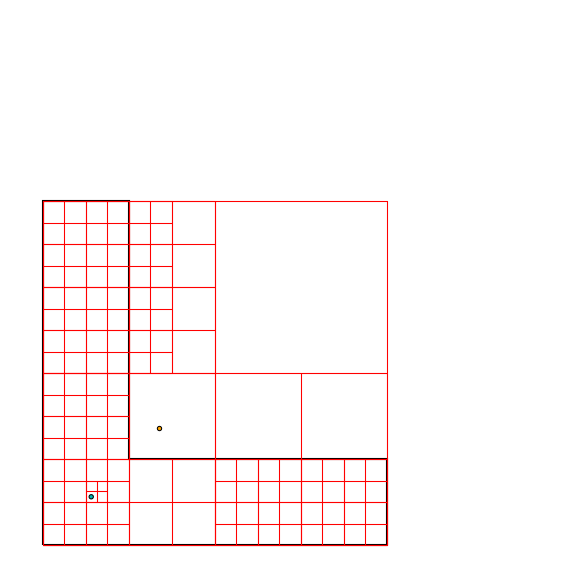

In [27]:
ppatches = [PolygonPatch(poly, fc='None', ec='#ff0000', alpha=1.0, zorder=3, lw=0.25) for poly in quad_polygons]

fig = plt.figure(1, figsize=(5., 5.), dpi=300)
ax = fig.add_subplot(121)
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
ax.set_xlim(-0.15, 6.0)
ax.set_ylim(-0.15, 6.0)

# add initial polygon
ax.add_patch(PolygonPatch(initial_polygon, fc='None', ec='#000000', lw=0.5, alpha=1.0, zorder=2))
# add centroid as dot patch
ax.add_patch(PolygonPatch(Point(1.3571, 1.3571).buffer(.025), lw=0.25, fc='#ffa500', ec='#000000', zorder=4))
plt.savefig("data/polylabel_000.png", format="png", bbox_inches='tight', alpha=True, transparent=True, dpi=300)

j = 0
for i, poly in enumerate(quad_polygons):
    j += 1
    ax.add_patch(ppatches[i])
    plt.savefig("data/polylabel_{:03d}.png".format(i + 1), format="png", bbox_inches='tight', alpha=True, transparent=True, dpi=300)

# add pole of inaccessibility as patch
ax.add_patch(PolygonPatch(Point(0.5625, 0.5625).buffer(.025), lw=0.25, fc='#00b3b3', ec='#000000', zorder=4))

# save final plot
plt.savefig("data/polylabel_{:03d}.png".format(j + 1), format="png", bbox_inches='tight', alpha=True, transparent=True, dpi=300)
plt.show()

In [29]:
%%bash
convert -background white -alpha remove -layers OptimizePlus -set delay 30 -colors 512 -loop 0 -scale 100% data/*.png output.gif